# GeoClaw dtopotools examples

This notebook contains some examples of working with the *clawpack.geoclaw.dtopotools* module.  These tools facilitate creating and manipulating the *dtopo* files that are required as GeoClaw input to specify moving topography, in particular the seafloor motion due to a subduction zone earthquake.  All the examples in this notebook are of this nature: slip on a fault surface (or in geneneral a collection of rectangular planar subfaults making up the fault) is converted to seafloor deformation by applying the Okada model. 

See <http://clawpack.github.io/doc/dtopotools.html> for general documentation of these tools and their use in the context of GeoClaw, and <http://www.clawpack.org> for more information on the Clawpack suite of software.

## Contents

 - <a href="#csv">Reading a csv file specifying the subfaults</a>
 - <a href="#plot-subfaults">Plot the subfault geometry and slip</a>
 - <a href="#plot-dz">Plot the seafloor displacement</a>
 - <a href="#create-dtopography">Create the dtopo file needed by GeoClaw</a>
 - <a href="#read-dtopo">Read in an existing dtopo file</a>
 - <a href="#sift">Create a fault using the NOAA SIFT database directly</a>
 - <a href="#time-dep">Time-dependent fault rupture</a>


### Setup notebook and environment:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from clawpack.geoclaw import dtopotools, topotools
import os
CLAW = os.environ['CLAW']
datadir = os.path.join(CLAW,'geoclaw','scratch') # directory for some sample data files

<div id="csv"></div>

## Reading a csv file specifying the subfaults

Read in a csv file where the first line labels the columns and the remaining lines give the parameters for each subfault. This is a model of the 1964 Alaska earthquake using 12 subfaults from the NOAA SIFT database of unit sources.  

See <http://nctr.pmel.noaa.gov/propagation-database.html> and
[gica2937.pdf](http://www.pmel.noaa.gov/pubs/PDF/gica2937/gica2937.pdf).

The full database is available at <http://sift.pmel.noaa.gov/ComMIT/compressed/info_sz.dat> and a later example in this notebook illustrates using the *dtopotools.SiftFault* class to access this directly.  But this example shows how a csv file can be specified.  The first line labels the columns with standard attributes needed to specify each subfault. 

Here is the raw file:

In [3]:
subfault_fname = 'data/alaska1964.csv'
print open(subfault_fname).read()

Longitude,Latitude,Depth(km),Length,Width,Strike,Dip,Rake,Slip,UnitSrc
204.89500,55.97000,17.94,100.0,50.0,236.000,15.000,90.0,19.5000,acsza31
205.34000,55.59800,5.00,100.0,50.0,236.000,15.000,90.0,19.5000,acszb31
206.20800,56.47300,17.94,100.0,50.0,236.000,15.000,90.0,24.5000,acsza32
206.65800,56.10000,5.00,100.0,50.0,236.000,15.000,90.0,24.5000,acszb32
207.53700,56.97500,17.94,100.0,50.0,236.000,15.000,90.0,29.5000,acsza33
207.99300,56.60300,5.00,100.0,50.0,236.000,15.000,90.0,29.5000,acszb33
208.93710,57.51240,17.94,100.0,50.0,236.000,15.000,90.0,34.5000,acsza34
209.40000,57.14000,5.00,100.0,50.0,236.000,15.000,90.0,34.5000,acszb34
210.25970,58.04410,17.94,100.0,50.0,230.000,15.000,90.0,34.5000,acsza35
210.80000,57.70000,5.00,100.0,50.0,230.000,15.000,90.0,34.5000,acszb35
211.32490,58.65650,17.94,100.0,50.0,218.000,15.000,90.0,34.5000,acsza36
212.00000,58.38000,5.00,100.0,50.0,218.000,15.000,90.0,34.5000,acszb36



Note that the last column has the name of the unit source from the NOAA SIFT database and will be ignored.  The other columns have labels that are expected.  Specify the units used for each and the coordinate system for the (longitude,latitude) and depth when reading the file in:

In [4]:
input_units = {"length":"km", "width":"km", "depth":"km", "slip":"m"}
fault = dtopotools.CSVFault()
fault.read(subfault_fname, input_units=input_units, coordinate_specification="noaa sift")

*** Warning: column name not recognized: unitsrc


You could skip directly to <a href="#create-dtopography">Create the dtopo file needed by GeoClaw</a>, but first we'll explore this fault model a bit...

The Seismic moment `Mo` and Moment Magnitude `Mw` can be computed using the `Fault` class methods:

In [5]:
print "The seismic moment is %g N-m" % fault.Mo()
print "The Moment magnitude is %g" % fault.Mw()
print "  (Assuming the rigidity mu of all subfaults is the default value %g Pa)"\
      % fault.subfaults[0].mu

The seismic moment is 7.08e+22 N-m
The Moment magnitude is 9.20002
  (Assuming the rigidity mu of all subfaults is the default value 4e+10 Pa)


<div id="plot-subfaults"></div>
### Plot the subfault geometry and slip

First with a vector showing the rake (direction of slip):

/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


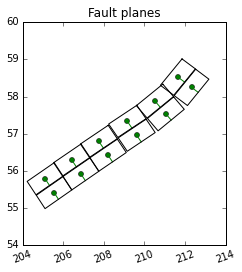

In [6]:
fault.plot_subfaults(plot_rake=True)

Plot again showing the magnitude of slip on each subfault:

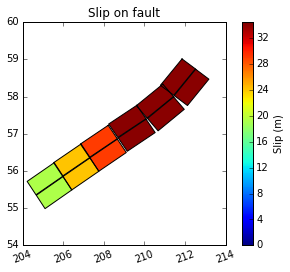

In [7]:
fault.plot_subfaults(slip_color=True)

Plot the coastline by downloading a file containing the x-y coordinates of shorelines based on etopo 4 minute data:

In [9]:
from clawpack.clawutil.data import get_remote_file
filename = 'pacific_shorelines_east_4min.npy'
url = 'http://www.geoclaw.org/topo/' + filename
get_remote_file(url=url, output_dir=datadir, force=True, verbose=True)
shorelines_file = os.path.join(datadir, filename)

File already exists, not downloading


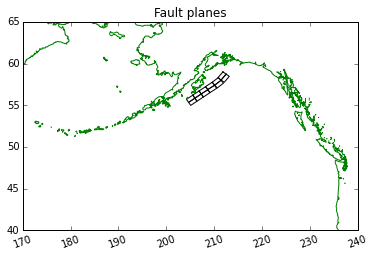

In [10]:
fault.plot_subfaults()
shore = load(shorelines_file)
plot(shore[:,0], shore[:,1], 'g')
axis([170,240,40,65])
gca().set_aspect(1./cos(55*pi/180.))

<div id="create-dtopography"></div>
### Create the dtopo file needed by GeoClaw:

Generate a dtopo grid by applying the Okada model to each subfault.  First we need to specify the region over which the seafloor deformation should be specified and the resolution of the grid:

In [11]:
xlower = 203.5
xupper = 214.  # approximate - adjusted below
ylower = 54.5
yupper = 60.  # approximate - adjusted below

# dtopo parameters:
points_per_degree = 60  # 1 minute resolution
dx = 1./points_per_degree
mx = int((xupper - xlower)/dx + 1)
xupper = xlower + (mx-1)*dx
my = int((yupper - ylower)/dx + 1)
yupper = ylower + (my-1)*dx

x = linspace(xlower,xupper,mx)
y = linspace(ylower,yupper,my)

Now apply Okada to create the static deformation at a single time $t = 1$ second:

In [12]:
dtopo = fault.create_dtopography(x,y,times=[1.], verbose=True)

Making Okada dz for each of 12 subfaults
0..1..2..3..4..5..6..7..8..9..10..11..
Done


We can save this deformation as a `dtopo` file with various `dtopo_type`s recognized by GeoClaw.  The most compact is `dtopo_type==3`, which specifies a header followed by all the `dZ` data:

In [13]:
dtopo_fname = os.path.join(datadir, 'alaska1964.tt3')
dtopo.write(dtopo_fname, dtopo_type=3)

Read the file in and print just the header.  (The remaining lines contain all the data.)

In [14]:
lines = open(dtopo_fname).readlines()
for k in range(9):
    print lines[k][:-1]

    631       mx 
    331       my 
      1       mt 
2.03500000000000e+02   xlower
5.45000000000000e+01   ylower
1.00000000000000e+00   t0
1.66666666666799e-02   dx
1.66666666666657e-02   dy
0.00000000000000e+00   dt


<div id="plot-dz"></div>
### Plot the seafloor displacement

[203.5, 214.0, 54.5, 62]

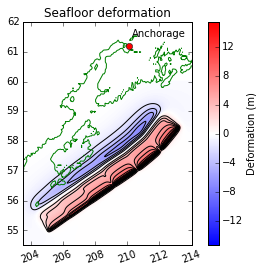

In [15]:
dtopo.plot_dZ_colors(t=1)

# add shoreline and Anchorage for orientation:
plot(shore[:,0], shore[:,1], 'g')
plot([210.1],[61.2],'ro')
text(210.3,61.5,'Anchorage')
axis([xlower,xupper,ylower,62])

<div id="read-dtopo"></div>

## Read in an existing dtopo file:

An existing dtopo file can be read in for plotting purposes or to further manipulate it.  To illustrate, we read in the file we just created...

In [16]:
dtopo2 = dtopotools.DTopography()
dtopo2.read(dtopo_fname, dtopo_type=3)

# Check that this data looks right:
assert len(dtopo2.x) == 631,  "*** length of x is wrong"
assert len(dtopo2.y) == 331,  "*** length of y is wrong"
dz_max = abs(dtopo2.dZ).max()
assert abs(dz_max - 15.368266081250006) < 1e-5,  "*** dz_max is wrong: %g" % dz_max
print "Looks ok"

Looks ok


<div id="sift"></div>

## Create a fault using the NOAA SIFT database directly

The example above showed how to read a csv file with arbitrary columns.  Since this particular fault is actually specified in terms of the NOAA SIFT unit sources, another option to create the same fault is to use the *dtopotools.SiftFault* class, which takes as an argument a dictionary *sift_slip* specifying the unit sources to be used and the slip on each.  

To illustrate, here we specify only the northern two and southern two unit sources from the example above, but with a dictionary of 12 unit sources we could recreate the full fault.

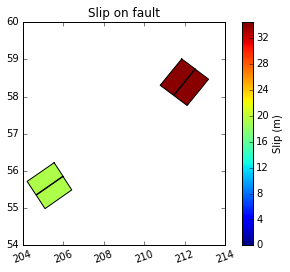

In [17]:
sift_slips = {'acsza31':19.5, 'acszb31':19.5, 'acsza36':34.5, 'acszb36':34.5}
f2 = dtopotools.SiftFault(sift_slips)
f2.plot_subfaults(slip_color=True)

<div id="time-dep"></div>

## Time-dependent fault rupture

This is synthetic data -- the same set of faults as before but with rupture occuring from south to north. Note that new columns `rupture_time` and `rise_time` have been added.

In [18]:
subfault_fname = 'data/timedep.csv'
print open(subfault_fname).read()

Longitude,Latitude,Depth(km),Length,Width,Strike,Dip,Rake,Slip,rupture_time,rise_time
204.89500,55.97000,17.94,100.0,50.0,236.000,15.000,90.0,19.5000,0,1
205.34000,55.59800,5.00,100.0,50.0,236.000,15.000,90.0,19.5000,1,1
206.20800,56.47300,17.94,100.0,50.0,236.000,15.000,90.0,24.5000,2,1
206.65800,56.10000,5.00,100.0,50.0,236.000,15.000,90.0,24.5000,3,1
207.53700,56.97500,17.94,100.0,50.0,236.000,15.000,90.0,29.5000,4,1
207.99300,56.60300,5.00,100.0,50.0,236.000,15.000,90.0,29.5000,5,1
208.93710,57.51240,17.94,100.0,50.0,236.000,15.000,90.0,34.5000,6,1
209.40000,57.14000,5.00,100.0,50.0,236.000,15.000,90.0,34.5000,7,1
210.25970,58.04410,17.94,100.0,50.0,230.000,15.000,90.0,34.5000,8,1
210.80000,57.70000,5.00,100.0,50.0,230.000,15.000,90.0,34.5000,9,1
211.32490,58.65650,17.94,100.0,50.0,218.000,15.000,90.0,34.5000,10,1
212.00000,58.38000,5.00,100.0,50.0,218.000,15.000,90.0,34.5000,11,1



Read in this csv file and set the parameters for the desired dtopo file:

In [19]:
input_units = {"length":"km", "width":"km", "depth":"km", 
               "slip":"m", "mu":"dyne/cm^2"}

fault = dtopotools.CSVFault()
fault.read(subfault_fname, input_units=input_units, 
           coordinate_specification="noaa sift")
fault.rupture_type = 'dynamic'

print "%s subfaults read in " % len(fault.subfaults)

xlower = 203.5
xupper = 214.
ylower = 54.5
yupper = 60.
xylim = [xlower,xupper,ylower,yupper]

# dtopo parameters:
points_per_degree = 60   # 1 minute resolution
mx = int((xupper - xlower)*points_per_degree + 1)
my = int((yupper - ylower)*points_per_degree + 1)
x = linspace(xlower,xupper,mx)
y = linspace(ylower,yupper,my)
print "dZ arrays will have shape %s by %s" % (len(y),len(x))


12 subfaults read in 
dZ arrays will have shape 331 by 631


Specify the desired output times, in this case 6 times between $t=0$ and $t=13$, when the rupture motion is complete.  Then apply the Okada model at each time (to the set of all subfaults with slips computed at each time based on the `rupture_time` and `rise_time` for that subfault).  Then `dtopo.dZ` will be a 3 dimensional array where each field at 6 different time points will be represented:

In [20]:
times = linspace(0,13,6)
dtopo = fault.create_dtopography(x,y,times=times)
print "Created array of dtopo deformations with shape", dtopo.dZ.shape

Created array of dtopo deformations with shape (6, 331, 631)


### Create an animation of the fault rupture

First define a function that will show time-dependent slip on the fault planes and resulting time-dependent seafloor motion in two side-by-side axes in the same figure:

In [21]:
# for setting color scale:
print "maximum abs(dz) over the full rupture time:", \
    abs(dtopo.dZ).max()

# Read in shoreline segments to give context in plots:
#shoreline_fname = os.path.join(datadir,'tohoku_shoreline_1min.npy')
#shoreline_xy = load(shoreline_fname)
shoreline_xy = shore

# Incorporate this function in dtopotools to replace animate_dz_colors?
def plot_subfaults_dZ(t, fig):
    fig.clf()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fault.plot_subfaults(axes=ax1, slip_color=True, 
                         slip_time=t, xylim=xylim)
    dtopo.plot_dZ_colors(axes=ax2, t=t, cmax_dZ=dz_max)
    ax1.plot(shoreline_xy[:,0],shoreline_xy[:,1],'g')
    ax2.plot(shoreline_xy[:,0],shoreline_xy[:,1],'g')
    ax2.set_xlim(xlower,xupper)
    ax2.set_ylim(ylower,yupper)
    return fig


maximum abs(dz) over the full rupture time: 15.3682660812


The loop below makes each plot and then saves it as a png file:

Figure files for each frame will be stored in  _plots
Saved  _plots/frame00000.png
Saved  _plots/frame00001.png
Saved  _plots/frame00002.png
Saved  _plots/frame00003.png
Saved  _plots/frame00004.png
Saved  _plots/frame00005.png
Final frame will be displayed below:


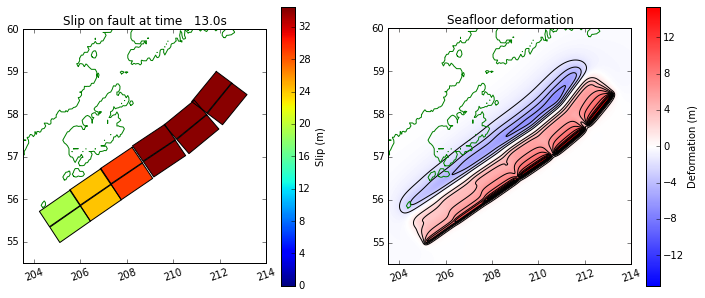

In [22]:
from clawpack.visclaw.JSAnimation import IPython_display
import clawpack.visclaw.JSAnimation.JSAnimation_frametools as J
plotdir = '_plots'
J.make_plotdir(plotdir, clobber=True)
fig = plt.figure(figsize=(12,5))

for k,t in enumerate(times):
    plot_subfaults_dZ(t,fig)
    J.save_frame(k, verbose=True)
    
print "Final frame will be displayed below:"

Combine the png files into an animation and display it:

In [23]:
anim = J.make_anim(plotdir)
anim